# ASL Fingerspelling Recognition

Created by Patrick Adams and Gail Goveas

#### Dowloading data from google cloud to local directory

In [36]:
#!pip install google-cloud-storage
#!pip install keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00


In [2]:
#importing and authenticating google colab
from google.cloud import storage
from google.colab import auth
auth.authenticate_user()

In [3]:
#creating a client object for Google Cloud storage
client = storage.Client()

#creating a reference to the Google Cloud bucket
bucket = client.get_bucket('asl_fingerspelling_project_bucket-1')
blob = bucket.blob('asl-fingerspelling/train.csv')
blob2 = bucket.blob('asl-fingerspelling/train_landmarks/1019715464.parquet')
blob3 = bucket.blob('asl-fingerspelling/character_to_prediction_index.json')

In [4]:
#downloading the data to a local file
blob.download_to_filename('train.csv')
blob2.download_to_filename('train_landmark1.parquet')
blob3.download_to_filename('character_to_prediction.json')

####Importing Packages

In [39]:
#importing packages
import pandas as pd
import pyarrow.parquet as pq
import json

import numpy as np

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Input

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tcn import TCN

#### Loading and understanding the Datasets

This section focuses on importing and getting familiar with the datasets.  A preliminary exploration is conducted to understand the structure and size of the metadata, landmark data and the character to prediction file. These steps establish a foundational understanding of the data's layout, content, and dimensions, allowing more in-depth analysis and processing.







In [6]:
# Loading and exploring the metadata
df = pd.read_csv('train.csv')
print(df.head())
print(f"shape of metadata is: {df.shape}")

                              path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  
0               3 creekhouse  
1            scales/kuhaylah  
2        1383 william lanier  
3          988 franklin lane  
4  6920 northeast 661st road  
shape of metadata is: (67208, 5)


The dataset 67,208 records distributed across five distinctive columns.
The features are as follows:

*  ***path***- Shows where the landmark file is stored.
*  ***file_id***- A unique identifier for the data file.
*  ***participant_id*** A unique identifier for the data contributor.
*  ***sequence_id*** - A unique identifier for the landmark sequence. Each data file may contain many sequences.

In the "train.csv" dataset, there is also a label called ***phrase***. The train and test datasets contain randomly generated addresses, phone numbers, and urls derived from components of real addresses/phone numbers/urls.


In [7]:
#Loading the landmark data which is a parquet file
df_landmark = pd.read_parquet('train_landmark1.parquet', engine='pyarrow')
print(df_landmark.head())
print(f"shape of landmark dataset is: {df_landmark.shape}")

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1975433633   0.582115  0.591430  0.498995  0.595773  ...        -0.253687   
1975433633   0.582197  0.591687  0.497613  0.596104  ...              NaN   
1975433633   0.581191  0.591550  0.497113  0.596477  ...        -0.233556   
1975433633   0.581652  0.591728  0.496759  0.596573  ...        -0.190909   
1975433633   0.581873  0.592467  

In [8]:
# Select a random row from the metadata
random_row = df.sample(n=1, random_state = 10)

# Extracting the 'sequence_id' and 'phrase' from the random row
sequence_id, phrase = random_row.iloc[0][['sequence_id', 'phrase']]

# Print the information
print(f"sequence_id: {sequence_id}, phrase: {phrase}")

# Extracting rows from the landmark file where the index matches sequence_id
sample_sequence_df = df_landmark.loc[sequence_id]
print(sample_sequence_df.head())
print(f"shape of {phrase} is: {sample_sequence_df.shape}")

sequence_id: 1990366432, phrase: erik hamilton
             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1990366432       0  0.605239  0.593421  0.596282  0.580097  0.592252   
1990366432       1  0.603645  0.592110  0.595200  0.579088  0.590954   
1990366432       2  0.603877  0.592069  0.595029  0.579474  0.591040   
1990366432       3  0.604464  0.592974  0.595711  0.580374  0.592028   
1990366432       4  0.608290  0.596224  0.598583  0.583649  0.595389   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1990366432   0.592052  0.592877  0.500375  0.591588  ...        -0.104486   
1990366432   0.590844  0.591982  0.500396  0.590895  ...        -0.077800   
1990366432   0.591081  0.592483  0.501297  0.591556  ...        -0.061390   
1990366432   0.592118  0.593550  0.501846  0.592731  ...       

This particular phrase 'erik hamilton' contains 142 entries and 1630 columns

In [9]:
#Parsing the JSON file into a Python Object

# Open and read the JSON file
with open('character_to_prediction.json', 'r') as file:
    char_to_pred = json.load(file)

# Print the data
print(char_to_pred)

{' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}


In [10]:
#Merging the data to add the label to the landmark data
combined_df = df_landmark.merge(df[['sequence_id', 'phrase']], how='left', left_index=True, right_on='sequence_id')
print(combined_df.head())
print(f"shape of merged data is: {combined_df.shape}")

       frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  x_face_5  \
30259      0  0.578892  0.578482  0.582906  0.572686  0.579030  0.582115   
30259      1  0.577563  0.578528  0.582916  0.572760  0.579090  0.582197   
30259      2  0.576181  0.576949  0.581346  0.572293  0.577725  0.581191   
30259      3  0.575575  0.577569  0.581769  0.572443  0.578289  0.581652   
30259      4  0.577907  0.577628  0.582295  0.572930  0.578345  0.581873   

       x_face_6  x_face_7  x_face_8  ...  z_right_hand_13  z_right_hand_14  \
30259  0.591430  0.498995  0.595773  ...        -0.123892        -0.195255   
30259  0.591687  0.497613  0.596104  ...              NaN              NaN   
30259  0.591550  0.497113  0.596477  ...        -0.116145        -0.179053   
30259  0.591728  0.496759  0.596573  ...        -0.093956        -0.149982   
30259  0.592467  0.498170  0.597383  ...              NaN              NaN   

       z_right_hand_15  z_right_hand_16  z_right_hand_17  z_right_hand_18 

In [11]:
#setting sequence_id as index
combined_df.set_index('sequence_id', inplace=True)
print(combined_df.head())

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_12  \
sequence_id                                          ...                    
1975433633   0.582115  0.591430  0.498995  0.595773  ...        -0.291687   
1975433633   0.582197  0.591687  0.497613  0.596104  ...              NaN   
1975433633   0.581191  0.591550  0.497113  0.596477  ...        -0.267114   
1975433633   0.581652  0.591728  0.496759  0.596573  ...        -0.218471   
1975433633   0.581873  0.592467  

### Preprocessing the Data



####Handling NaN Values


In [12]:
#Checking if the dataset has NaN values
combined_df.isna()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20,phrase
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008677531,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
2008677531,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
2008677531,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False


In [13]:
#Filling the NaN values with 0
combined_df = combined_df.fillna(0)

In [14]:
#Confirming there are no NaN values present
combined_df.isna().sum()

frame              0
x_face_0           0
x_face_1           0
x_face_2           0
x_face_3           0
                  ..
z_right_hand_17    0
z_right_hand_18    0
z_right_hand_19    0
z_right_hand_20    0
phrase             0
Length: 1631, dtype: int64

####Normalising Features

In [15]:
# Initializing StandardScaler
scaler = StandardScaler()

# Creating a list to hold the normalized features for each sequence
normalized_features = []

# Grouping the data by 'sequence_id' index
for sequence_id, group in combined_df.groupby(level=0):

    # Sorting the group by the 'frame' column to ensure the correct temporal order
    group_sorted = group.sort_values(by='frame')

    # Extracting features from the sorted group, excluding the 'frame' and 'phrase' columns
    features = group_sorted.drop(columns=['frame', 'phrase'], errors='ignore').values

    # Normalizing the features
    normalized_features.append(scaler.fit_transform(features))

####Padding Features

In [16]:
# Determine the maximum sequence length if not already known (should be same as for labels)
max_feature_sequence_length = max(len(sequence) for sequence in normalized_features)
print(f"Maximum sequence length of features is: {max_feature_sequence_length}")

# Pad the feature sequences
padded_features = pad_sequences(normalized_features, maxlen=max_feature_sequence_length, padding='post', dtype='float32')


Maximum sequence length of features is: 751


####Encoding and Padding the Label Sequences

In [17]:
# Group by 'sequence_id' and select the last 'phrase' of each group
labels_df = combined_df.groupby(level=0)['phrase'].last()
print(labels_df.head())

sequence_id
1975433633                +95-335-395
1975473601         bugs.launchpad.net
1975502450    mirandasphysiosteps.com
1975521182          5 endeavor circle
1975541698               +44-4560-846
Name: phrase, dtype: object


In [18]:
# If you need this as a DataFrame:
labels_df = labels_df.reset_index()
# Converting phrases to sequence of integers using char_to_pred
label_sequences = [[char_to_pred[char] for char in phrase] for phrase in labels_df['phrase']]

In [19]:
# Calculating the maximum length of the sequences
max_sequence_length = max(len(sequence) for sequence in label_sequences)
print(f"Maximum sequence length of phrase is: {max_sequence_length}")

# Padding the sequence labels
padded_label_sequences = pad_sequences(label_sequences, maxlen=max_sequence_length, padding='post')
print(f"Shape of the padded label sequences is: {padded_label_sequences.shape}")

Maximum sequence length of phrase is: 30
Shape of the padded label sequences is: (998, 30)


In [20]:
#Accounting for padding by adding 1 to the length
num_classes = len(char_to_pred) + 1
print(f"The number of classes is: {num_classes}")

#One-hot encoding the last label of each sequence for a many-to-one setup
last_label_indices = padded_label_sequences[:, -1]  # This gets the last label index for each sequence
one_hot_labels = to_categorical(last_label_indices, num_classes=num_classes)

# Checking the shape of the one-hot encoded labels
print(f"Shape of the One-Hot Encoded labels is: {one_hot_labels.shape}")


The number of classes is: 60
Shape of the One-Hot Encoded labels is: (998, 60)


In [21]:
print("Shape of padded_features:", padded_features.shape)  # Expected: (998, max_sequence_length, number_of_features)
print("Shape of one_hot_labels:", one_hot_labels.shape)    # Expected: (998, num_classes)


Shape of padded_features: (998, 751, 1629)
Shape of one_hot_labels: (998, 60)


####Splitting Data

In [40]:
# Splitting into training and remaining data
X_train, X_temp, y_train, y_temp = train_test_split(padded_features, one_hot_labels, test_size=0.3, random_state=42)

# Now splitting the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



###LSTM Model

In [ ]:
# Defining the LSTM model
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(751, 1629)))

# Adding a dropout layer for regularization
model.add(Dropout(0.2))

# Adding another LSTM layer, return_sequences is False to return only the last output for the sequence
model.add(LSTM(units=50))

# Adding another dropout layer
model.add(Dropout(0.2))

# Output layer with 'softmax' activation, units equal to the number of classes (60)
model.add(Dense(units=60, activation='softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 751, 50)           336000    
                                                                 
 dropout (Dropout)           (None, 751, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 60)                3060      
                                                                 
Total params: 359260 (1.37 MB)
Trainable params: 359260 (1.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Training the model
history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 3.9975 - accuracy: 0.9812 - val_loss: 3.7240 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 2.4563 - accuracy: 0.9828 - val_loss: 1.0598 - val_accuracy: 0.9688
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.6284 - accuracy: 0.9828 - val_loss: 0.3661 - val_accuracy: 0.9688
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.2243 - accuracy: 0.9828 - val_loss: 0.2729 - val_accuracy: 0.9688
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.1672 - accuracy: 0.9828 - val_loss: 0.2655 - val_accuracy: 0.9688
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.1774 - accuracy: 0.9781 - val_loss: 0.2649 - val_accuracy: 0.9688
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 0.1528 - accuracy: 0.9828 - val_loss: 0.2642 - val_accuracy: 0.9688
Epoch 8/10
10/10 [==

In [ ]:
#Evaluating model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 2s 258ms/step - loss: 0.2915 - accuracy: 0.9650
Test Accuracy: 0.9649999737739563


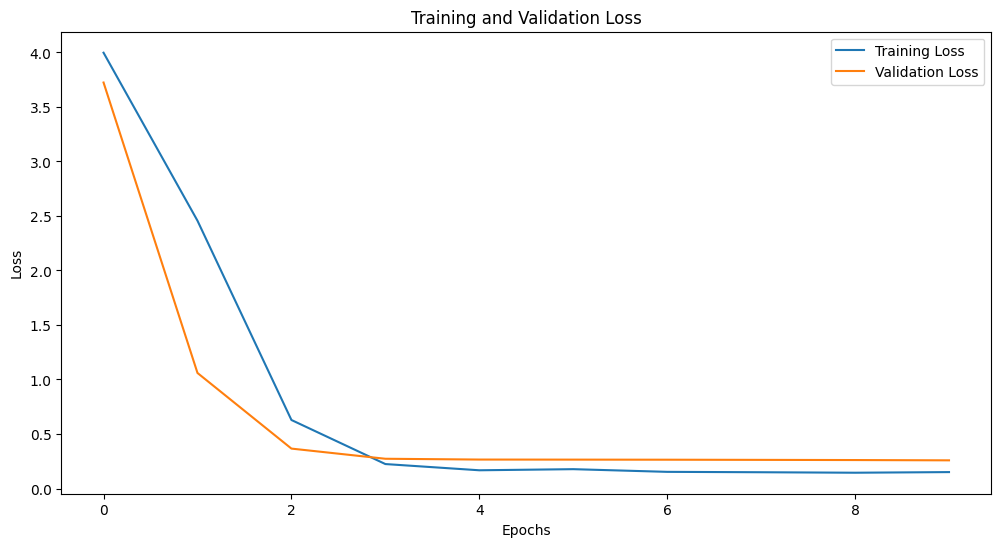

In [ ]:
# Assuming 'history' is the output from the model.fit() method
history_dict = history.history

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


###GRU Model

In [23]:
#GRU Model Architecture
def create_gru_model():
    model = Sequential()
    model.add(GRU(units=128, return_sequences=True, input_shape=(751, 1629)))
    model.add(GRU(units=128))
    model.add(Dense(60, activation='softmax'))  # 60 classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Creating the model
gru_model = create_gru_model()

# Model summary
gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 751, 128)          675456    
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 60)                7740      
                                                                 
Total params: 782268 (2.98 MB)
Trainable params: 782268 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('gru_model.h5', monitor='val_loss', save_best_only=True)

#Compiling the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training the model
history_gru = gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
10/10 [==============================] - 27s 2s/step - loss: 3.7497 - accuracy: 0.9812 - val_loss: 2.5534 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.6656 - accuracy: 0.9828 - val_loss: 0.4404 - val_accuracy: 0.9688
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.2340 - accuracy: 0.9828 - val_loss: 0.4444 - val_accuracy: 0.9688
Epoch 4/10
10/10 [==============================] - 20s 2s/step - loss: 0.2242 - accuracy: 0.9828 - val_loss: 0.4290 - val_accuracy: 0.9688
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.2097 - accuracy: 0.9828 - val_loss: 0.4027 - val_accuracy: 0.9688
Epoch 6/10
10/10 [==============================] - 20s 2s/step - loss: 0.1915 - accuracy: 0.9828 - val_loss: 0.3749 - val_accuracy: 0.9688
Epoch 7/10
10/10 [==============================] - 20s 2s/step - loss: 0.1787 - accuracy: 0.9828 - val_loss: 0.3418 - val_accuracy: 0.9688
Epoch 8/10
10/10 [==

In [32]:
#Evaluating model
test_loss, test_accuracy = gru_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 3s 361ms/step - loss: 0.3807 - accuracy: 0.9650
Test Accuracy: 0.9649999737739563


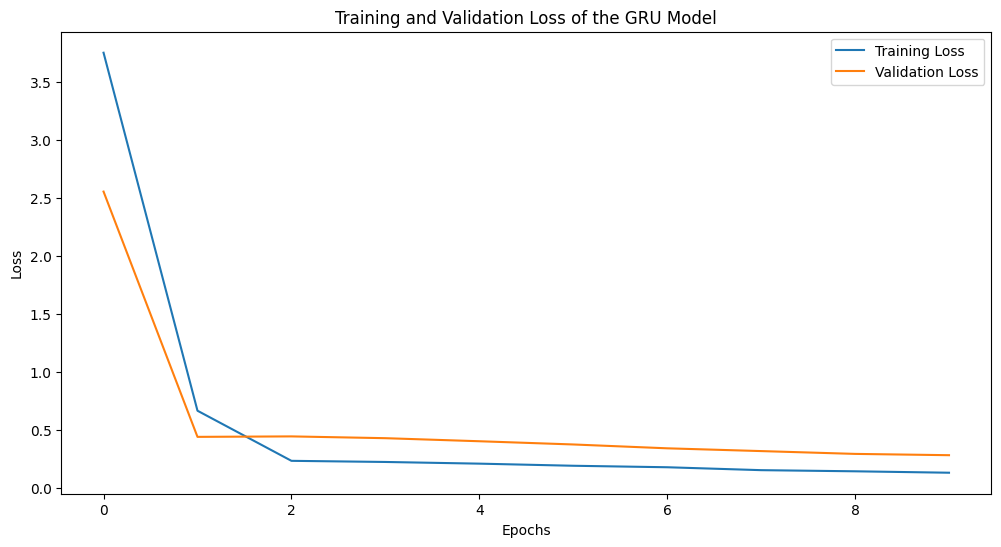

In [33]:
history_dict_gru = history_gru.history

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history_dict_gru['loss'], label='Training Loss')
plt.plot(history_dict_gru['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the GRU Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


###TCN Model

In [38]:
#Definig TCN Model Architecture
def create_tcn_model():
    input_shape = (751, 1629)  # Sequence length x number of features
    num_classes = 60  # Number of output classes

    input_layer = Input(shape=input_shape)
    tcn_layer = TCN(nb_filters=32, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4, 8, 16], padding='causal', return_sequences=False)(input_layer)
    output_layer = Dense(num_classes, activation='softmax')(tcn_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
tcn_model = create_tcn_model()

# Model summary to verify the architecture
tcn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 751, 1629)]       0         
                                                                 
 tcn (TCN)                   (None, 32)                267552    
                                                                 
 dense_1 (Dense)             (None, 60)                1980      
                                                                 
Total params: 269532 (1.03 MB)
Trainable params: 269532 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Compile the model
tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_tcn = tcn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/10
11/11 [==============================] - 17s 1s/step - loss: 3.5605 - accuracy: 0.4370 - val_loss: 0.7110 - val_accuracy: 0.9733
Epoch 2/10
11/11 [==============================] - 10s 910ms/step - loss: 0.4941 - accuracy: 0.9771 - val_loss: 0.6069 - val_accuracy: 0.9733
Epoch 3/10
11/11 [==============================] - 10s 937ms/step - loss: 0.3193 - accuracy: 0.9771 - val_loss: 0.3359 - val_accuracy: 0.9733
Epoch 4/10
11/11 [==============================] - 11s 975ms/step - loss: 0.2319 - accuracy: 0.9771 - val_loss: 0.2977 - val_accuracy: 0.9733
Epoch 5/10
11/11 [==============================] - 10s 950ms/step - loss: 0.2096 - accuracy: 0.9771 - val_loss: 0.2731 - val_accuracy: 0.9733
Epoch 6/10
11/11 [==============================] - 10s 929ms/step - loss: 0.2044 - accuracy: 0.9771 - val_loss: 0.2716 - val_accuracy: 0.9733
Epoch 7/10
11/11 [==============================] - 10s 956ms/step - loss: 0.1929 - accuracy: 0.9771 - val_loss: 0.2716 - val_accuracy: 0.9733
Ep

In [42]:
# Evaluate the model
test_loss, test_accuracy = tcn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 [==============================] - 1s 154ms/step - loss: 0.1662 - accuracy: 0.9800
Test Loss: 0.16621653735637665
Test Accuracy: 0.9800000190734863


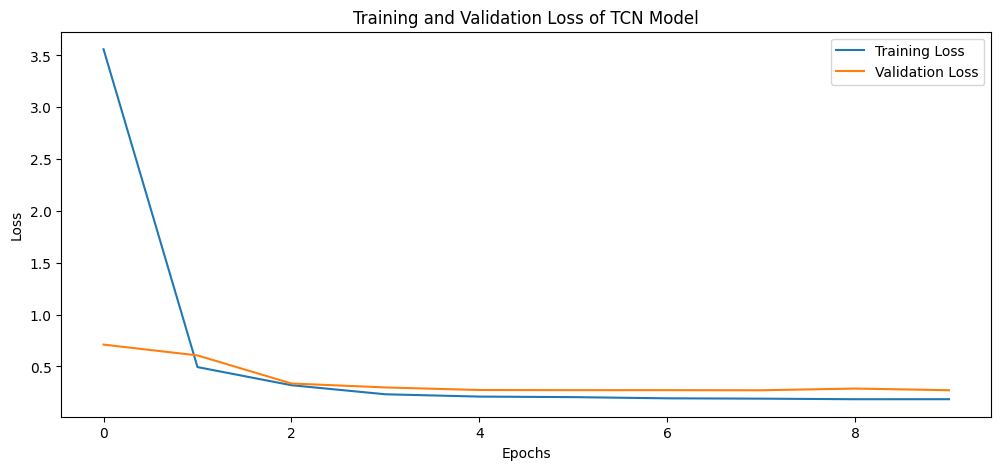

In [44]:
# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.plot(history_tcn.history['loss'], label='Training Loss')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of TCN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()